# SENTIMENT ANALYSIS ON VACCINATION TWEETS

### <b style="color:blue">Developed by:</b> 
### Name: Anand Vadavelli,  Redid: 823389639
### Name: Harshita Sai Atluri, Redid: 83

### <b style="color:blue">Overview:</b> 
<p> For this project, we first initally decided to do sentiment analysis on apple products by live streaming the twitter data however twitter did not approve developer account in time. Therefore we picked a <a href="https://www.kaggle.com/keplaxo/twitter-vaccination-dataset"><strong>kaggle dataset</strong></a> on vaccination that has sentiment analysis in pandas. We decided to do the sentiment analysis on this data set with pyspark dataframe. Because we also got the twitter developer account approved towards the end of may second week, we attempted to stream the vaccination tweets for learning purpose that can be found in the later half of this notebook. </p>  

### <b style="color:blue">Learning:<br/></b> 
<p>With this project we had a great learning curve towards pyspark dataframes. How is it different from pandas dataframe. We had an opportunity to learn how a spark streaming can be done with a developer twitter account </p>

### <b style="color:blue">Issues Faced:<br/></b> 
<p>1.Initally setting up spark on local boxes did have issues. we learned how to fix those issues <br\>
   2.Though the syntax of spark dataframe is a bit similar to pandas we had challenges on finding out the syntax for spark dataframe.</p>

### <b style="color:blue">Prerequisities:<br/></b> 
<font color='green'>
    Before running this notebook, please install the following libraries:<br>
pip install tweepy<br>
pip install matplotlib<br>
pip install seaborn<br>
pip install pandas<br>
pip install wordcloud<br>
pip install nltk<br>
pip install punkt<br>
pip install vaderSentiment <br>
pip install ginsm   
</font>


<Strong>Before running this note book, install spacy<br></Strong>
<font color='green'>
    python -m spacy download en<br>
conda install -c conda-forge spacy<br>
python -m spacy download en<br>
python -m download en_core_web_md<br>
pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz --no-deps
</font>

<Strong> Import the necessary required libraries </Strong>

In [1]:
%%time
import findspark
findspark.init()
import pyspark
import random
import warnings 
import matplotlib.pyplot as plt 
import seaborn as sns
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.types import DateType
from pyspark.sql import SQLContext
from pyspark.sql.functions import monotonically_increasing_id
import string
import nltk
from nltk.corpus import stopwords
from nltk import re
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.sql.functions import udf
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore", category=DeprecationWarning)

Wall time: 4.75 s


<Strong>Import the necessary required libraries</Strong>

In [2]:
%%time
sc = SparkContext('local', appName="Vaccination tweets analysis")
spark = SparkSession(sc)

Wall time: 17.6 s


<Strong>Read the csv file</Strong>

In [3]:
%%time
dataFile = 'vaccination2.csv'
reader = spark.read 
reader.option("header",True)
reader.option("inferSchema",True)
vaccination_tweets = reader.csv(dataFile)

Wall time: 11.2 s


<Strong> Lets looks the data and the fields available</Strong>

In [4]:
vaccination_tweets.show(5)

+-------------------+-------------------+-------------+----------+--------+--------------------+----------+---------------+--------------------+-----+--------------------+--------------------+--------------------+------+-------------+--------------+-----------+-----------+--------+--------------------+-------+--------------------+-----+----+----+------+----------+-------+----------+--------------------+------------+
|                 id|    conversation_id|   created_at|      date|    time|            timezone|   user_id|       username|                name|place|               tweet|            mentions|                urls|photos|replies_count|retweets_count|likes_count|   hashtags|cashtags|                link|retweet|           quote_url|video|near| geo|source|user_rt_id|user_rt|retweet_id|            reply_to|retweet_date|
+-------------------+-------------------+-------------+----------+--------+--------------------+----------+---------------+--------------------+-----+----------

<Strong>Now lets look the all the available columns and the dataframe schema</Strong>

In [5]:
%%time
# print('Dataset size:',vaccination_tweets.describe().show())
print('Columns are:',vaccination_tweets.columns)
print('Schema: ', vaccination_tweets.printSchema())

Columns are: ['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone', 'user_id', 'username', 'name', 'place', 'tweet', 'mentions', 'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count', 'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video', 'near', 'geo', 'source', 'user_rt_id', 'user_rt', 'retweet_id', 'reply_to', 'retweet_date']
root
 |-- id: string (nullable = true)
 |-- conversation_id: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- timezone: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- username: string (nullable = true)
 |-- name: string (nullable = true)
 |-- place: string (nullable = true)
 |-- tweet: string (nullable = true)
 |-- mentions: string (nullable = true)
 |-- urls: string (nullable = true)
 |-- photos: string (nullable = true)
 |-- replies_count: string (nullable = true)
 |-- retweets_count: string (nullable = true)
 

<Strong>For our analysis we consider tweets, date of the tweet and hastags in the tweet</Strong>

In [6]:
%%time
vaccination_tweets = vaccination_tweets.select(vaccination_tweets['date'].cast(DateType()), "tweet", "hashtags") 

Wall time: 84 ms


<Strong>Lets look the data we filtered out</Strong>

In [7]:
vaccination_tweets.show(10)

+----------+--------------------+--------------------+
|      date|               tweet|            hashtags|
+----------+--------------------+--------------------+
|2019-10-03|Thinks:  ... teta...|                  []|
|2019-10-03|Forced Vaccinatio...|                  []|
|2019-10-03|We have had our f...|                  []|
|2019-10-03|That's true, they...|                  []|
|2019-10-03|Flu vaccination d...|         ['#fluvax']|
|2019-10-03|What did farmers ...|['#tbfree', '#bad...|
|2019-10-03|An employee at Tu...|                  []|
|2019-10-03|#Nigeria: An outb...|        ['#nigeria']|
|2019-10-03|Impressive number...|['#vaccination', ...|
|2019-10-03|⁦@DrBGellin⁩ @Sab...|['#research', '#v...|
+----------+--------------------+--------------------+
only showing top 10 rows



<p><Strong>Data Processing:<br/></Strong>
Any data from social media platforms like twitter has to properly cleaned to analyze the data.<br/>
    We will do the following on this data<br/>
    1. Removing the ulrs from the tweets<br/>
    2. Removing twitter handles<br/>
    3. Removing twitter reserve words<br/>
    4. Removing punctuations<br>
    5. Removing single letter words<br/>
    6. Removing blank spaces<br/>
    7. Removing stop words<br/>
    8. Removing numbers<br/>
    9. Tokenization<br/>
    10. Stemming<br/>
</p>

<Strong>This below methods help us to process our data</Strong>

In [8]:
nltk.download('punkt')
nltk.download('stopwords')

MIN_YEAR = 1900
MAX_YEAR = 2100


def get_url_patern():
    return re.compile(
        r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))'
        r'[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})')


def get_emojis_pattern():
    try:
        # UCS-4
        emojis_pattern = re.compile(u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])')
    except re.error:
        # UCS-2
        emojis_pattern = re.compile(
            u'([\u2600-\u27BF])|([\uD83C][\uDF00-\uDFFF])|([\uD83D][\uDC00-\uDE4F])|([\uD83D][\uDE80-\uDEFF])')
    return emojis_pattern


def get_hashtags_pattern():
    return re.compile(r'#\w*')


def get_single_letter_words_pattern():
    return re.compile(r'(?<![\w\-])\w(?![\w\-])')


def get_blank_spaces_pattern():
    return re.compile(r'\s{2,}|\t')


def get_twitter_reserved_words_pattern():
    return re.compile(r'(RT|rt|FAV|fav|VIA|via)')


def get_mentions_pattern():
    return re.compile(r'@\w*')


def is_year(text):
    if (len(text) == 3 or len(text) == 4) and (MIN_YEAR < len(text) < MAX_YEAR):
        return True
    else:
        return False


class TwitterPreprocessor:

    def __init__(self, text: str):
        self.text = text

    def fully_preprocess(self):
        return self \
            .remove_urls() \
            .remove_mentions() \
            .remove_hashtags() \
            .remove_twitter_reserved_words() \
            .remove_punctuation() \
            .remove_single_letter_words() \
            .remove_blank_spaces() \
            .remove_stopwords() \
            .remove_numbers()

    def remove_urls(self):
        self.text = re.sub(pattern=get_url_patern(), repl='', string=self.text)
        return self

    def remove_punctuation(self):
        self.text = self.text.translate(str.maketrans('', '', string.punctuation))
        return self

    def remove_mentions(self):
        self.text = re.sub(pattern=get_mentions_pattern(), repl='', string=self.text)
        return self

    def remove_hashtags(self):
        self.text = re.sub(pattern=get_hashtags_pattern(), repl='', string=self.text)
        return self

    def remove_twitter_reserved_words(self):
        self.text = re.sub(pattern=get_twitter_reserved_words_pattern(), repl='', string=self.text)
        return self

    def remove_single_letter_words(self):
        self.text = re.sub(pattern=get_single_letter_words_pattern(), repl='', string=self.text)
        return self

    def remove_blank_spaces(self):
        self.text = re.sub(pattern=get_blank_spaces_pattern(), repl=' ', string=self.text)
        return self

    def remove_stopwords(self, extra_stopwords=None):
        if extra_stopwords is None:
            extra_stopwords = []
        text = nltk.word_tokenize(self.text)
        stop_words = set(stopwords.words('english'))

        new_sentence = []
        for w in text:
            if w not in stop_words and w not in extra_stopwords:
                new_sentence.append(w)
        self.text = ' '.join(new_sentence)
        return self

    def remove_numbers(self, preserve_years=False):
        text_list = self.text.split(' ')
        for text in text_list:
            if text.isnumeric():
                if preserve_years:
                    if not is_year(text):
                        text_list.remove(text)
                else:
                    text_list.remove(text)

        self.text = ' '.join(text_list)
        return self

    def lowercase(self):
        self.text = self.text.lower()
        return self

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\avadavelli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\avadavelli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Strong>Now lets process the data cleaning on tweets column and append it to a list</Strong>

In [9]:
%%time
tweets = [str(row.tweet) for row in vaccination_tweets.collect()]
clean_tweets = []
for tweet in tweets:
    c = TwitterPreprocessor((tweet))
    c.fully_preprocess()
    c = c.text
    clean_tweets.append(c)    

Wall time: 1min 12s


<Strong>Lets create a pandas dataframe for the processed list and convert into spark dataframe</Strong>

In [10]:
%%time
sqlContext = SQLContext(sc)
cleaned_tweets_pandas = pd.DataFrame(clean_tweets, columns={'clean_tweets'})
cleaned_tweets = spark.createDataFrame(cleaned_tweets_pandas)

Wall time: 2.3 s


<Strong>Lets look at the processed tweets spark dataframe</Strong>

In [11]:
cleaned_tweets.head(10)

[Row(clean_tweets='Thinks tetanus vaccination currently 😉'),
 Row(clean_tweets='Forced Vaccination Its Ties To Eugenics David Icke'),
 Row(clean_tweets='We flu vaccination protect patients staff families …'),
 Row(clean_tweets='Thats true known contraindications vaccination Docs know stuff'),
 Row(clean_tweets='Flu vaccination pregnancy safe helps protect mothers flu pregnancy helps protect babies several months bih This impoant since babies months ’ get'),
 Row(clean_tweets='What farmers make Badger Vaccination Deployment Project views changed time Our longitudinal analysis … ££ free …'),
 Row(clean_tweets='An employee Turning Stone Reso Casino Oneida County diagnosed infectious hepatitis last week forcing hurried vaccination guests workers pictwittercomhTCAB8muoj'),
 Row(clean_tweets='An outbreak yellow fever ongoing Proof vaccination required enter country If travel area consult health care professional least weeks trip protect insect bites httpowlyHCzl50wAr9b'),
 Row(clean_tweets='

<Strong>Lets us merge the cleaned tweets dataframe with the orginial dataframe</Strong>

In [12]:
%%time
vaccination_tweets = vaccination_tweets.withColumn("id", monotonically_increasing_id())
cleaned_tweets = cleaned_tweets.withColumn("id", monotonically_increasing_id())
vaccination_tweets = cleaned_tweets.join(vaccination_tweets, "id", "outer").drop("id")

Wall time: 85 ms


<Strong>Let us look at the combined dataframe</Strong>  

In [13]:
vaccination_tweets.show()

+--------------------+----------+--------------------+--------------------+
|        clean_tweets|      date|               tweet|            hashtags|
+--------------------+----------+--------------------+--------------------+
|On Fri PM Swindon...|2019-10-03|On Fri at 2 PM: S...|                  []|
|If member SHSU co...|2019-10-03|If you are a memb...|                  []|
|The move give tee...|2019-10-03|"""The move to gi...|                   0|
|cases decision ba...|2019-10-02|#Didyouknow, in m...|['#didyouknow', '...|
|Thats helpful sin...|2019-10-01|That's it helpful...|                  []|
|Get involved Wear...|2019-10-01|Get involved this...|['#hpvpreventionw...|
|Vaccine Death Sto...|2019-10-01|Vaccine Death Sto...|                  []|
|Doctrine Original...|2019-10-01|Doctrine of Origi...|['#antigenic', '#...|
|Could someone tel...|2019-10-01|Could someone tel...|    ['#vaccination']|
|Great Many health...|2019-10-01|"Great! Many heal...|                   1|
|annual flu 

### Data Analysis
<Strong>We would want to look at the words that are commonly used in tweets. For this we will use word cloud visualization<br/></Strong>
<Strong>In word cloud, the words that are fequently used will appear is bigger font</Strong>
<p>For this we will first get all words in the tweets as a list</p>

In [14]:
%%time
tweets_row_list = vaccination_tweets.select('clean_tweets').collect()
tweets_string_list = [ ele.__getattr__('clean_tweets') for ele in tweets_row_list]
all_tweet_words = ' '.join(tweets_string_list)

Wall time: 9.11 s


<Strong>Plot the word cloud</Strong>

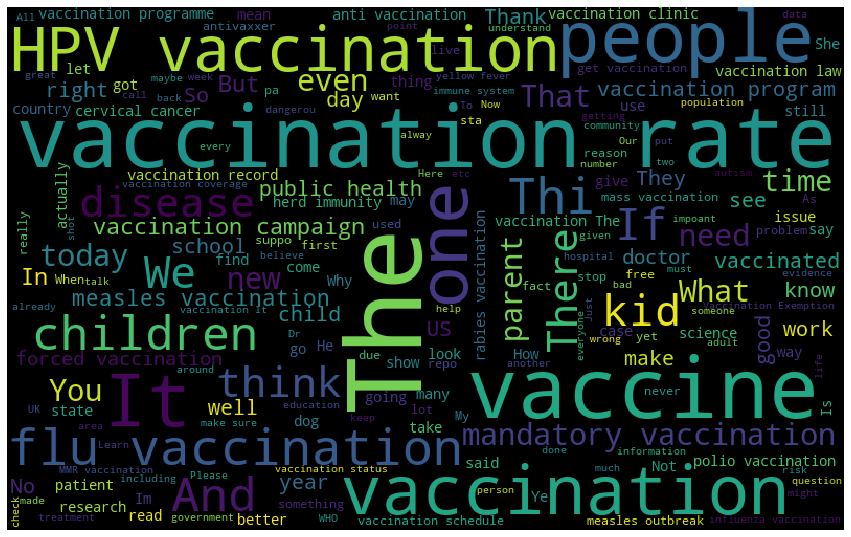

Wall time: 17.2 s


In [15]:
%%time
wordcloud = WordCloud(width=800, height=500, random_state=None, max_font_size=100).generate(all_tweet_words)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="nearest")
plt.axis('off')
plt.show()

### Sentiment Analysis Using VADER
<p>Vader has the ability to handles emojis and slangs. It also considers capitalization and punctuations when giving the scores<br/>
Vader gives 4 types of values, positive, negative, neutral and compound<br/>
</p>    

In [16]:
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\avadavelli\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

<p>
Create a sentiment intensity analyzer object<br/>
Plot a graph based on the tweets compund polarity score<br/>
</p>    

Wall time: 26.3 s


(array([ 1527.,  3168.,  3478.,  4133.,  4178.,  3901.,  5497.,  3240.,
         2492., 22404.,  2999.,  2197.,  3928.,  4735.,  6192.,  3927.,
         4305.,  3652.,  2928.,  1097.]),
 array([-0.9887 , -0.88971, -0.79072, -0.69173, -0.59274, -0.49375,
        -0.39476, -0.29577, -0.19678, -0.09779,  0.0012 ,  0.10019,
         0.19918,  0.29817,  0.39716,  0.49615,  0.59514,  0.69413,
         0.79312,  0.89211,  0.9911 ]),
 <a list of 20 Patch objects>)

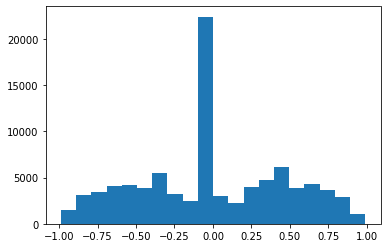

In [17]:
%%time
analyzer = SentimentIntensityAnalyzer()
scores = [analyzer.polarity_scores(tweet)['compound'] for tweet in tweets_string_list]
plt.hist(scores, bins=20)

<p><Strong>Let us calculate the pos, neu, neg and compund polarity scores on each tweet and save it</Strong><br/>
<Strong><b style="color:red">Note: We tried to save the polarity scores directly to the dataframe with the below commented logic however performing calculation on these dataframes was taking very long time. Also we couldn't figure out how with a single lamda function we could save all the polarity scores instead of calculating it individually.</b></Strong><br/>
<Strong><b style="color:green">So we decided to calculate polarity score to a list and then merge to the original dataframe</b></Strong></p>

In [18]:
# %%time
# from pyspark.sql.functions import udf
# compound = udf(lambda x: analyzer.polarity_scores(x)['compound'])
# pos = udf(lambda x: analyzer.polarity_scores(x)['pos'])
# neu = udf(lambda x: analyzer.polarity_scores(x)['neu'])
# neg = udf(lambda x: analyzer.polarity_scores(x)['neg'])

# vaccination_tweets = vaccination_tweets.withColumn('compound', compound('clean_tweets'))
# vaccination_tweets = vaccination_tweets.withColumn('pos', pos('clean_tweets'))
# vaccination_tweets = vaccination_tweets.withColumn('neu', neu('clean_tweets'))
# vaccination_tweets = vaccination_tweets.withColumn('neg', neg('clean_tweets'))
# vaccination_tweets.head(5)

In [19]:
tweet_compound = []
tweet_pos = []
tweet_neu = []
tweet_neg = []

In [20]:
%%time
for row in vaccination_tweets.rdd.toLocalIterator():
    polarity_score = analyzer.polarity_scores(row['clean_tweets'])
    tweet_pos.append(polarity_score['pos'])
    tweet_neu.append(polarity_score['neu'])
    tweet_neg.append(polarity_score['neg'])
    tweet_compound.append(polarity_score['compound'])

Wall time: 39.9 s


<Strong>Create a spark datafram for the pos, neu, neg and compund polarity scores</Strong>

In [21]:
%%time
polarity_scores = sqlContext.createDataFrame(zip(tweet_pos, tweet_neu, tweet_neg, tweet_compound), \
                                          schema=['tweet_pos', 'tweet_neu', 'tweet_neg', 'tweet_compound'])


Wall time: 3.44 s


<Strong>Let us look at polarity values summary</Strong>

In [22]:
polarity_scores.describe().show()

+-------+-------------------+-------------------+-------------------+--------------------+
|summary|          tweet_pos|          tweet_neu|          tweet_neg|      tweet_compound|
+-------+-------------------+-------------------+-------------------+--------------------+
|  count|              89978|              89978|              89978|               89978|
|   mean|0.12912954277712102| 0.7493477183311529|0.12137703660894938|0.006552779568339026|
| stddev|0.14713526566230858|0.18748644581485913|0.14935563082922684|  0.4730808963660294|
|    min|                0.0|                0.0|                0.0|             -0.9887|
|    max|                1.0|                1.0|                1.0|              0.9911|
+-------+-------------------+-------------------+-------------------+--------------------+



<Strong>Let us merge the polarity scores with the original dataframe</Strong>
<p>Though there are many ways to merge lists to spark dataframe, we preffered using spark sql to acheive this</p>

In [23]:
%%time
polarity_scores = polarity_scores.withColumn("id", monotonically_increasing_id())
polarity_scores.createOrReplaceTempView("metrics")
polarity_scores_sql = spark.sql("SELECT * FROM metrics")
# polarity_scores_sql.show()

Wall time: 429 ms


In [24]:
%%time
vaccination_tweets = vaccination_tweets.withColumn("id", monotonically_increasing_id())
vaccination_tweets.createOrReplaceTempView("tweets")
vaccination_tweets_sql = spark.sql("SELECT * FROM tweets")
# vaccination_tweets_sql.show()

Wall time: 41 ms


In [25]:
%%time
vaccination_tweets_merged = vaccination_tweets_sql.join(polarity_scores_sql, 'id', 'inner')

Wall time: 14 ms


<Strong>Let us look at the our new dataframe with the polarity values</Strong>

In [26]:
%%time
vaccination_tweets_merged.show()
vaccination_tweets_merged.printSchema()
# vaccination_tweets_merged.describe().show()

+---+--------------------+----------+--------------------+--------------------+---------+---------+---------+--------------+
| id|        clean_tweets|      date|               tweet|            hashtags|tweet_pos|tweet_neu|tweet_neg|tweet_compound|
+---+--------------------+----------+--------------------+--------------------+---------+---------+---------+--------------+
| 26|Reasons NOT To Ge...|2019-09-26|RT @drgarynull: 5...|                  []|      0.0|      1.0|      0.0|           0.0|
| 29|Social media acti...|2019-09-25|Social media acti...|                  []|      0.0|    0.784|    0.216|       -0.7003|
| 65|TRUE COLOURS THE ...|2019-09-18|"TRUE COLOURS THE...|                  []|    0.152|    0.489|    0.359|       -0.5859|
|191|In province far c...|2019-08-20|In #Uruzgan provi...|['#uruzgan', '#en...|    0.195|    0.805|      0.0|        0.6249|
|418|California Assemb...|2019-06-21|A California Asse...|                  []|      0.0|      1.0|      0.0|           0.0|


### Lets analyze on how the hashtags contributed to the tweets sentiment

In [27]:
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

<Strong>Get the hastags with compound score <, >, and =0 in to seperate dataframes</Strong>

In [28]:
%%time
vaccination_tweets_merged.createOrReplaceTempView("tweets")
neutral_hashtag = spark.sql("SELECT hashtags FROM tweets WHERE tweet_compound = 0")
negative_hashtag = spark.sql("SELECT hashtags FROM tweets WHERE tweet_compound < 0")
postivie_hashtag = spark.sql("SELECT hashtags FROM tweets WHERE tweet_compound > 0")

Wall time: 133 ms


### Hashtags with positive polarity

In [29]:
%%time
postivie_hashtag_row_list = postivie_hashtag.collect()
postivie_hashtag_string_list = [ ele.__getattr__('hashtags') for ele in postivie_hashtag_row_list]
postivie_tweets=hashtag_extract(postivie_hashtag_string_list)
postivie_tweets = sum(postivie_tweets,[])

Wall time: 2min 53s


<p><Strong>Plot a heat map and a bar graph for the positive tweets</Strong></p>
<Strong>    
<b style="color:red">Note: We tried to plot directly using the spark dataframe however we couldn't get much help of plotting through spark dataframe therfore used pandas dataframe for this usecase</b></Strong><br/>
</p>

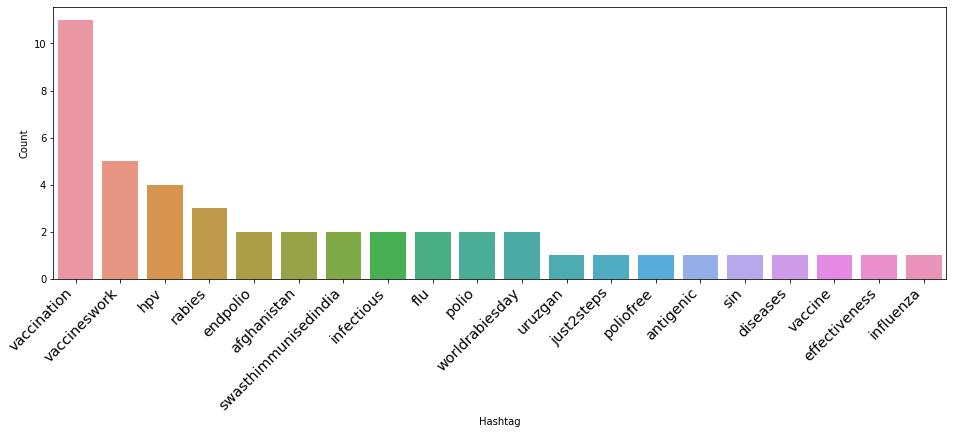

Wall time: 844 ms


In [30]:
%%time
pos_tweets = nltk.FreqDist(postivie_tweets)
pos_tweets_df = pd.DataFrame({'Hashtag': list(pos_tweets.keys()),
                  'Count': list(pos_tweets.values())})

# selecting top 20 most frequent hashtags     
pos_tweets_df = pos_tweets_df.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=pos_tweets_df, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

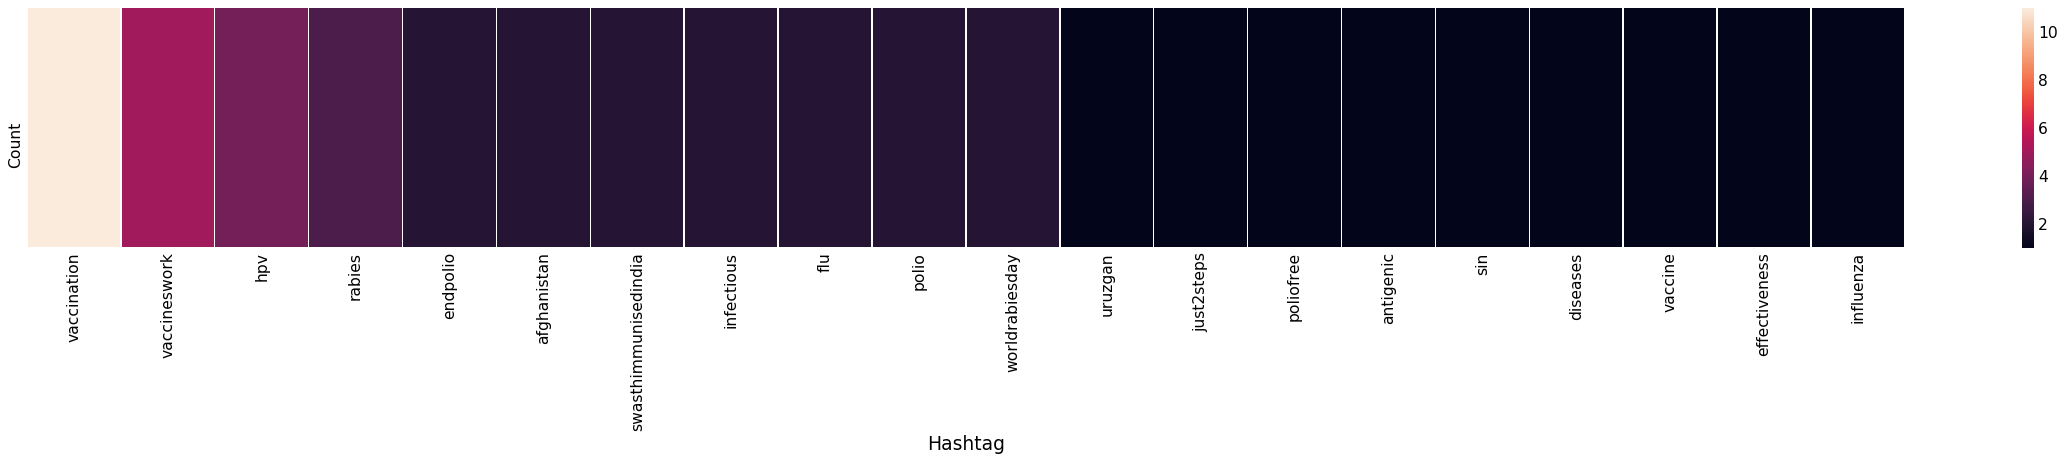

Wall time: 913 ms


In [31]:
%%time
pos_tweets_df.set_index('Hashtag', inplace=True)
pos_tweets_df = pos_tweets_df.T
# Plot a heatmap for these hashtags
from matplotlib.pyplot import figure
figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
plt.style.use('fivethirtyeight')
ax = sns.heatmap(linewidth=0.5, data=pos_tweets_df)
plt.tight_layout()
plt.show()

### Hashtags with negative polarity

In [32]:
%%time
negative_hashtag_row_list = negative_hashtag.collect()
negative_hashtag_string_list = [ ele.__getattr__('hashtags') for ele in negative_hashtag_row_list]
negative_tweets=hashtag_extract(negative_hashtag_string_list)
negative_tweets = sum(negative_tweets,[])

Wall time: 2min 44s


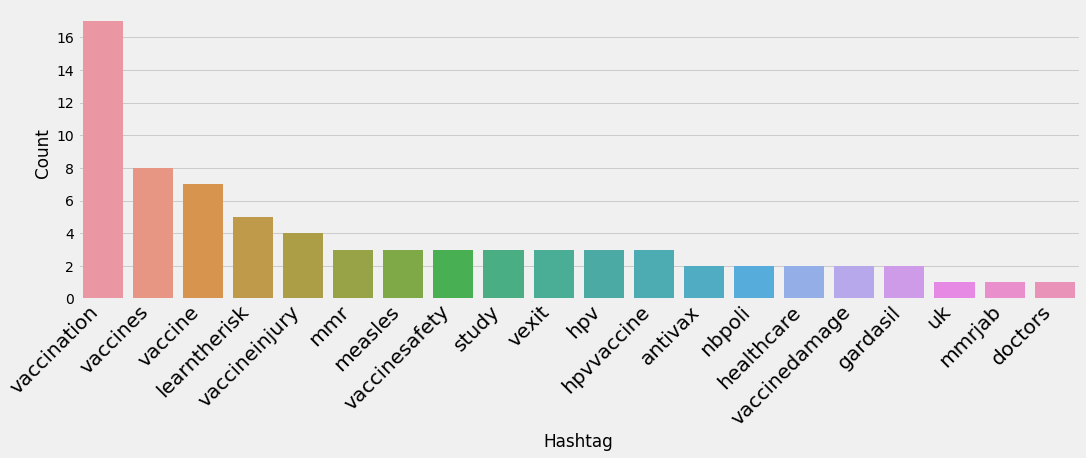

Wall time: 930 ms


In [33]:
%%time
neg_tweets = nltk.FreqDist(negative_tweets)
neg_tweets_df = pd.DataFrame({'Hashtag': list(neg_tweets.keys()),
                  'Count': list(neg_tweets.values())})

# selecting top 20 most frequent hashtags     
neg_tweets_df = neg_tweets_df.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=neg_tweets_df, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

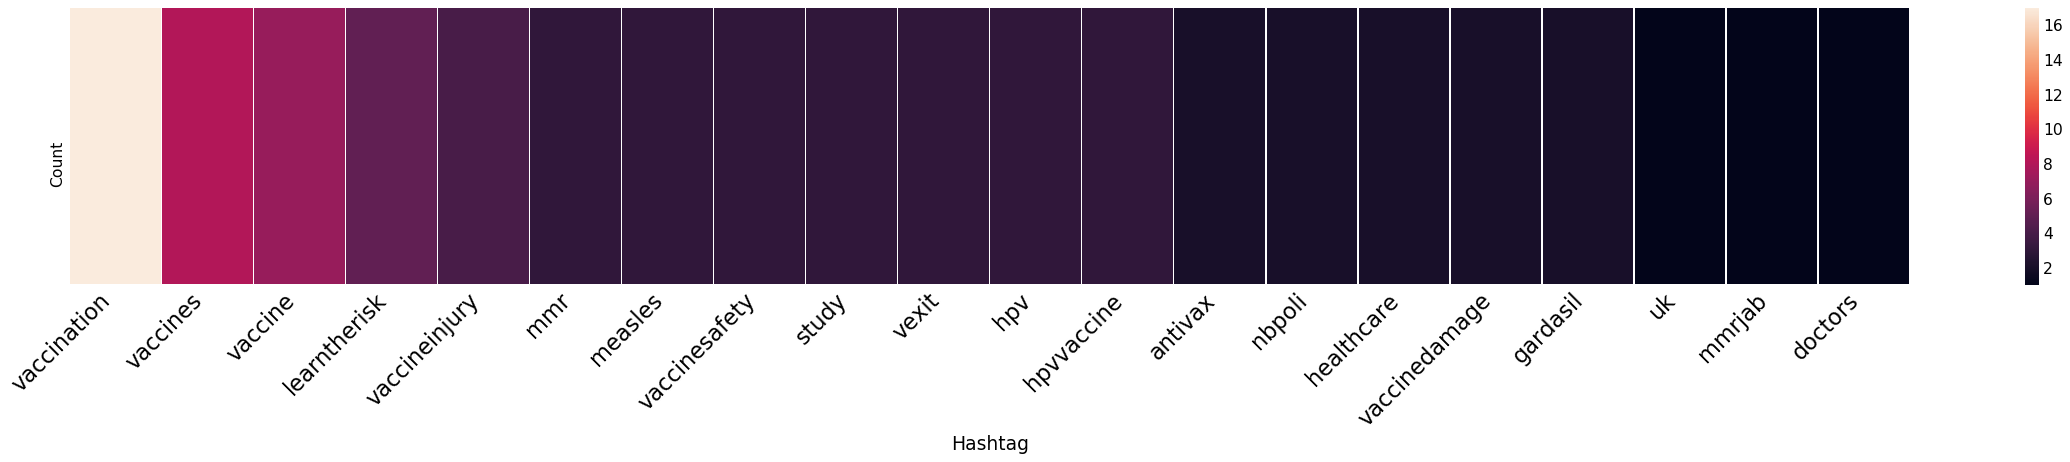

Wall time: 581 ms


In [34]:
%%time
neg_tweets_df.set_index('Hashtag', inplace=True)
neg_tweets_df = neg_tweets_df.T
# Plot a heatmap for these hashtags
from matplotlib.pyplot import figure
figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
plt.style.use('fivethirtyeight')
ax = sns.heatmap(linewidth=0.5, data=neg_tweets_df)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.tight_layout()
plt.show()

### Hashtags with neutral polarity

In [35]:
%%time
neutral_hashtag_row_list = neutral_hashtag.collect()
neutral_hashtag_string_list = [ ele.__getattr__('hashtags') for ele in neutral_hashtag_row_list]
neutral_tweets=hashtag_extract(neutral_hashtag_string_list)
neutral_tweets = sum(neutral_tweets,[])

Wall time: 2min 26s


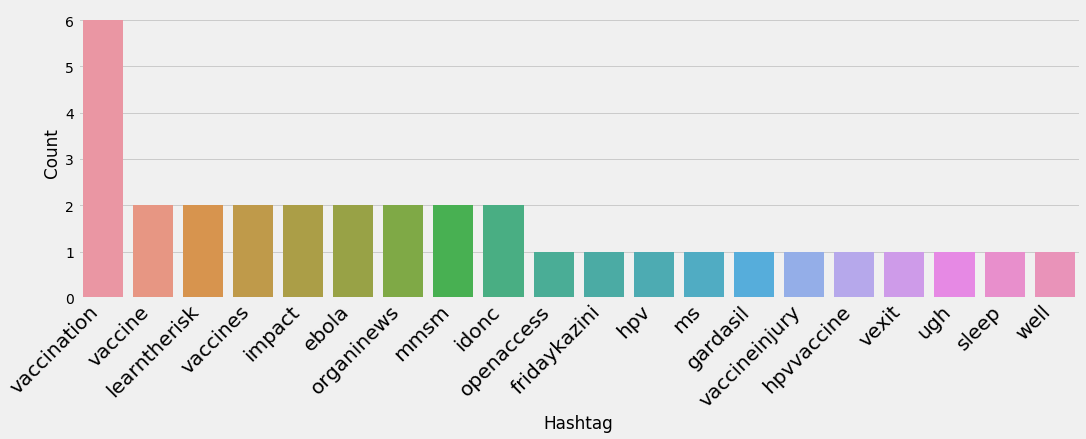

Wall time: 415 ms


In [36]:
%%time
neu_tweets = nltk.FreqDist(neutral_tweets)
neu_tweets_df = pd.DataFrame({'Hashtag': list(neu_tweets.keys()),
                  'Count': list(neu_tweets.values())})

# selecting top 20 most frequent hashtags     
neu_tweets_df = neu_tweets_df.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=neu_tweets_df, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

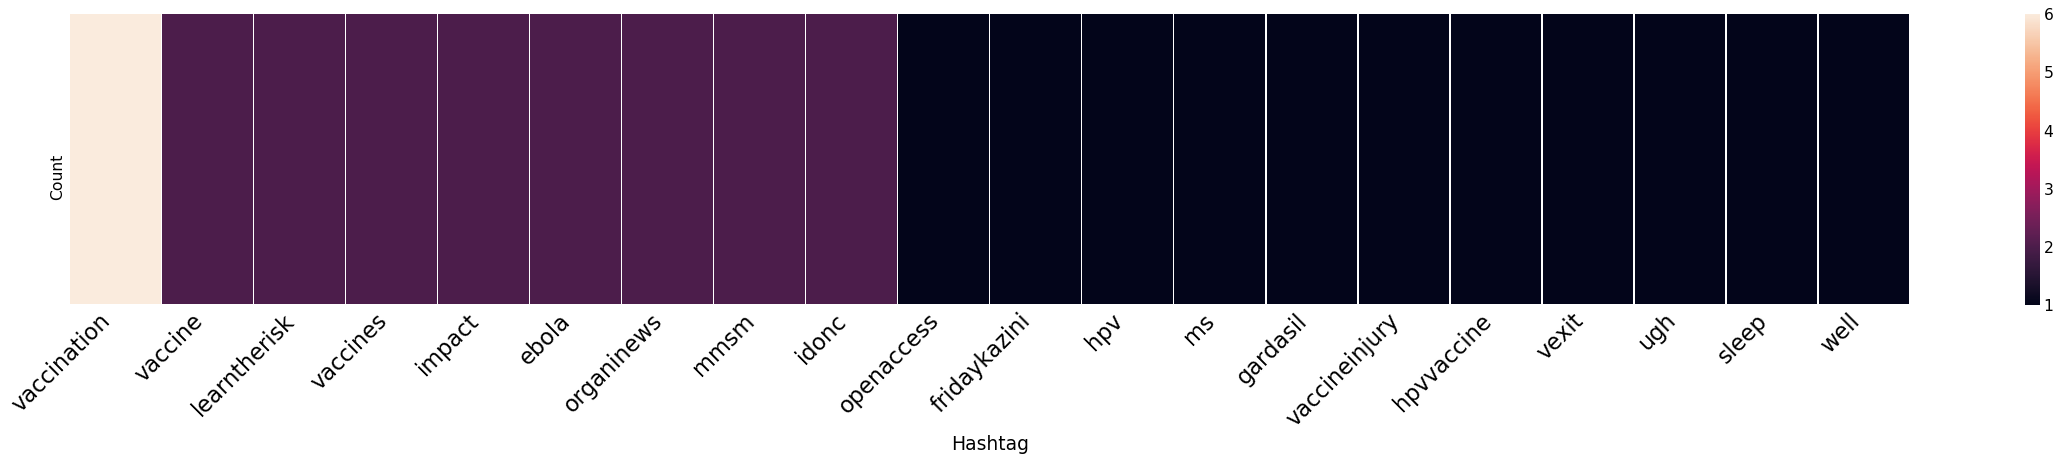

Wall time: 2.29 s


In [37]:
%%time
neu_tweets_df.set_index('Hashtag', inplace=True)
neu_tweets_df = neu_tweets_df.T
# Plot a heatmap for these hashtags
from matplotlib.pyplot import figure
figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
plt.style.use('fivethirtyeight')
ax = sns.heatmap(linewidth=0.5, data=neu_tweets_df)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.tight_layout()
plt.show()

### Lets perform a topic modem analysis

In [38]:
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_',\
                   'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice',\
                   'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want',\
                   'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

<Strong>Remove new line characters, single quotes and split the sentence into a list of words using gensim’s simple_preprocess()</Strong>

In [39]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent) 
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

<Strong></Strong>

In [40]:
%%time
all_tweets = vaccination_tweets.select('clean_tweets')
all_tweets_row_list = all_tweets.collect()
all_tweets_string_list = [ ele.__getattr__('clean_tweets') for ele in all_tweets_row_list]

all_tweets_words = list(sent_to_words(all_tweets_string_list))
print(all_tweets_words[:1])

[['on', 'fri', 'pm', 'swindon', 'borough', 'council', 'staff', 'flu', 'vaccination', 'attachment', 'lead', 'training', 'schools', 'day', 'louise', 'bomber', 'company', 'ad', 'astra', 'hustlers', 'kitchen', 'the', 'rambo', 'last', 'blood']]
Wall time: 15.3 s


In [41]:
# # print(string.punctuation)
# import string
# table = str.maketrans('', '', string.punctuation)
# stripped = [tweet.translate(table) for tweet in all_tweets_words[1]]
# words = [tweet.lower() for tweet in all_tweets_words[1]]
# print(words[:100])

In [42]:
# %%time
# tokens = []
# from nltk.tokenize import word_tokenize
# for tweet in all_tweets_string_list:
#     tweet = tweet.lower()
#     tweet = tweet.translate(str.maketrans('', '', string.punctuation))
# #     tweet = [word for word in tweet if word.isalpha()]
#     tokens.append(word_tokenize(tweet))
# print(tokens[:100])
# # words = [word for word in tokens if word.isalpha()]

In [43]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(all_tweets_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[all_tweets_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[all_tweets_words[0]]])

['on', 'fri', 'pm', 'swindon_borough_council', 'staff', 'flu', 'vaccination', 'attachment', 'lead', 'training', 'schools', 'day', 'louise', 'bomber', 'company', 'ad', 'astra', 'hustlers', 'kitchen', 'the', 'rambo', 'last', 'blood']


In [44]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [45]:
# Remove Stop Words
data_words_nostops = remove_stopwords(all_tweets_words)

In [46]:
# Form Bigrams
data_words_bigrams = make_bigrams(all_tweets_words)

In [47]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [48]:
%%time
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['vaccination', 'attachment', 'lead', 'training', 'school', 'hustler', 'kitchen', 'last', 'blood']]
Wall time: 5min 59s


In [49]:

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [50]:
%%time
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

Wall time: 21min 15s


In [51]:
%%time
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.108*"spread" + 0.088*"keep" + 0.082*"live" + 0.072*"include" + 0.067*"safe" + 0.066*"put" + 0.056*"share" + 0.053*"visit" + 0.053*"global" + 0.052*"human"'), (1, '0.000*"infowar" + 0.000*"clamor" + 0.000*"schoolready" + 0.000*"selfcare" + 0.000*"qlqhnrkm" + 0.000*"gainframe" + 0.000*"lossframe" + 0.000*"fwiw" + 0.000*"tast" + 0.000*"momcat"'), (2, '0.241*"day" + 0.205*"die" + 0.116*"due" + 0.058*"mother" + 0.035*"bit" + 0.034*"wonder" + 0.028*"district" + 0.027*"arm" + 0.019*"field" + 0.015*"responsible"'), (3, '0.268*"find" + 0.108*"sick" + 0.085*"compulsory" + 0.079*"team" + 0.073*"idea" + 0.070*"compare" + 0.052*"rule" + 0.022*"truly" + 0.000*"science" + 0.000*"state"'), (4, '0.237*"be" + 0.175*"work" + 0.155*"today" + 0.087*"follow" + 0.077*"thank" + 0.033*"ill" + 0.027*"news" + 0.024*"chance" + 0.024*"hepatitis" + 0.022*"annual"'), (5, '0.134*"go" + 0.095*"campaign" + 0.085*"free" + 0.083*"force" + 0.082*"antivaccination" + 0.079*"rabie" + 0.057*"much" + 0.051*"clinic" + 0

In [52]:
%%time
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -17.160180171575583

Coherence Score:  0.2766924361577916
Wall time: 59 s


In [55]:
%%time
import pyLDAvis
from pyLDAvis import gensim
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

Wall time: 2min 15s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.359898  0.304320       1        1  23.942421
18     0.108681 -0.212382       2        1   7.076324
14     0.110771 -0.219107       3        1   6.880514
7      0.076700 -0.098222       4        1   5.761821
17     0.058286 -0.060859       5        1   5.649732
10     0.047873 -0.044526       6        1   5.455257
6      0.049810 -0.047281       7        1   5.378940
16     0.032348 -0.024085       8        1   4.923106
5      0.014150 -0.005344       9        1   4.550256
12    -0.011323  0.014802      10        1   4.117047
13    -0.008107  0.012834      11        1   4.108133
8      0.001818  0.004306      12        1   4.074372
15    -0.031484  0.027090      13        1   3.583456
19    -0.027428  0.024234      14        1   3.569906
0     -0.076749  0.046906      15        1   2.784156
4     -0.079558  0.047603      16        1   2.780835
11    -0.080833  0.048103      17        1   2.655796
2     -0.149813  0.063607      18        1   1.606742
3     -0.186651  0.065653      19        1   1.084333
1     -0.208390  0.052348      20        1   0.016849, topic_info=               Term          Freq          Total Category  logprob  loglift
8       vaccination  143613.00000  143613.000000  Default  30.0000  30.0000
34          vaccine   21331.00000   21331.000000  Default  29.0000  29.0000
126           child   17922.00000   17922.000000  Default  28.0000  28.0000
312             get   12813.00000   12813.000000  Default  27.0000  27.0000
573          people   11140.00000   11140.000000  Default  26.0000  26.0000
...             ...           ...            ...      ...      ...      ...
11988  lincolnshire       0.00447       1.579458  Topic20 -10.4891   2.8212
11986      cvumzjdu       0.00447       1.579458  Topic20 -10.4891   2.8212
11979      sickjust       0.00447       1.579458  Topic20 -10.4891   2.8212
11985       homedye       0.00447       1.579458  Topic20 -10.4891   2.8212
11984      fluwhile       0.00447       1.579458  Topic20 -10.4891   2.8212

[905 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
306      18  0.976561     ache
272      12  0.997959   action
139      11  0.997517      add
202      10  0.999349    adult
345       3  0.996953  african
...     ...       ...      ...
174       3  0.999793    would
451       7  0.998931    write
608      11  0.998207    wrong
158       5  0.999777     year
207      10  0.999369    young

[403 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 19, 15, 8, 18, 11, 7, 17, 6, 13, 14, 9, 16, 20, 1, 5, 12, 3, 4, 2])